# Project Prototype 2

## Goal

The goal of this phase of this prototype is to see if review data is better for determining an apps rating than the summary data I've previously used. I plan on doing this by building a predictor for the sentiment of the user reviews as a baseline first, even though the data includes this as a column already. I also plan to test a neural network using the user reviews to see if it can predict app ratings with a higher accuracy than the model made in prototype 1.

## Data Cleaning

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('googleplaystore_user_reviews.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


In [3]:
# Removing all null values from the user reviews
df = df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37427 entries, 0 to 64230
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     37427 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37427 non-null  object 
 3   Sentiment_Polarity      37427 non-null  float64
 4   Sentiment_Subjectivity  37427 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.7+ MB


In [4]:
# Add in app ratings from original dataset
og = pd.read_csv('googleplaystore.csv')

df['Rating'] = ''    # Blank column to add ratings into

for row in df.index:
    appRating = (None, None)    # Tuple containing app name and rating
    a = df.loc[row, 'App']    # Gets the name of the app from the review dataset
    
    if appRating[0] == a:    # Checks to see if we already have the rating for the current app
        df.loc[row, 'Rating'] = appRating[1]    # Adds the rating into the reviews dataframe
    
    elif og['App'].eq(a).any():    # Checks to see if the app name is present in the original dataframe
        index = og[og['App'] == a].index.values[0]    # Gets the index of the app name
        appRating = (row, og.loc[index, 'Rating'])    # Saves the app name and its rating
        df.loc[row, 'Rating'] = appRating[1]    # Adds the rating into the reviews dataframe
        
    else:
        df.loc[row, 'Rating'] = None    # Sets the rating of the app to null if it cannot be found
        
df = df.dropna()    # Removes reviews if no valid app score was found

In [5]:
# Changing the data type of the rating to float
df['Rating'] = df['Rating'].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35929 entries, 0 to 64230
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     35929 non-null  object 
 1   Translated_Review       35929 non-null  object 
 2   Sentiment               35929 non-null  object 
 3   Sentiment_Polarity      35929 non-null  float64
 4   Sentiment_Subjectivity  35929 non-null  float64
 5   Rating                  35929 non-null  float64
dtypes: float64(3), object(3)
memory usage: 1.9+ MB


In [6]:
# Saving the newly cleaned data
df.to_csv('google_reviews_cleaned.csv', index=False)

## Exploratory Data Analysis

In [7]:
# Loading the cleaned data
df = pd.read_csv('google_reviews_cleaned.csv')

df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Rating
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333,4.0
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462,4.0
2,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000,4.0
3,10 Best Foods for You,Best idea us,Positive,1.00,0.300000,4.0
4,10 Best Foods for You,Best way,Positive,1.00,0.300000,4.0


In [4]:
# Summary statistics for the numeric columns
df.describe()

,Sentiment_Polarity,Sentiment_Subjectivity,Rating
count,35929.000000,35929.000000,35929.000000
mean,0.180904,0.493767,4.297197
std,0.350080,0.258053,0.303176
min,-1.000000,0.000000,2.600000
25%,0.000000,0.361111,4.100000
50%,0.150000,0.514835,4.300000
75%,0.400000,0.650000,4.500000
max,1.000000,1.000000,4.900000


In [8]:
# Checking total number of unique elements in categorical columns
print(len(df))
print('App unique values:', len(df['App'].value_counts()))
print('Sentiment unique values:', len(df['Sentiment'].value_counts()))
print(df['Sentiment'].unique())

35929
App unique values: 816
Sentiment unique values: 3
['Positive' 'Neutral' 'Negative']


In [6]:
# Correlation table for the numeric columns
df.corr()

,Sentiment_Polarity,Sentiment_Subjectivity,Rating
Sentiment_Polarity,1.000000,0.259668,0.092903
Sentiment_Subjectivity,0.259668,1.000000,0.068758
Rating,0.092903,0.068758,1.000000


### Determining most common words in reviews of various sentiments

In [9]:
# Importing natural language processing tools
import nltk
from nltk import tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kyle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kyle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# Splits reviews by sentiment
positive = df.loc[df['Sentiment'] == 'Positive', 'Translated_Review']
negative = df.loc[df['Sentiment'] == 'Negative', 'Translated_Review']
neutral = df.loc[df['Sentiment'] == 'Neutral', 'Translated_Review']

In [12]:
# Removing spaces
pos_reviews = positive.str.cat(sep=' ')
neg_reviews = negative.str.cat(sep=' ')
nt_reviews = neutral.str.cat(sep=' ')

In [ ]:
print(pos_reviews)

In [158]:
# Separates reviews into individual words (very slow)
pos_tokens = tokenize.word_tokenize(pos_reviews)
neg_tokens = tokenize.word_tokenize(neg_reviews)
nt_tokens = tokenize.word_tokenize(nt_reviews)

In [149]:
# Removing stop words
stop_words = set(stopwords.words('english'))    # Creats a list of stop words to remove

pos_words = [w.lower() for w in pos_tokens if not w.lower() in stop_words]
neg_words = [w.lower() for w in neg_tokens if not w.lower() in stop_words]
nt_words = [w.lower() for w in nt_tokens if not w.lower() in stop_words]

In [150]:
# Removing punctuation
pos_words = [w for w in pos_words if w.isalpha()]
neg_words = [w for w in neg_words if w.isalpha()]
nt_words = [w for w in nt_words if w.isalpha()]

In [151]:
# Determining frequency of all words
pos_freq = {}

for w in pos_words:
    if w in pos_freq.keys():    # Searches the disctionary to see if the word is already present
        pos_freq[w] = pos_freq[w] + 1
    else:    # Adds word to dictionary if not present
        pos_freq[w] = 1

sorted_words = sorted(pos_freq.items(), key=lambda x:x[1], reverse=True)
pos_freq = dict(sorted_words)

neg_freq = {}

for w in neg_words:
    if w in neg_freq.keys():    # Searches the disctionary to see if the word is already present
        neg_freq[w] = neg_freq[w] + 1
    else:    # Adds word to dictionary if not present
        neg_freq[w] = 1

sorted_words = sorted(neg_freq.items(), key=lambda x:x[1], reverse=True)
neg_freq = dict(sorted_words)

nt_freq = {}

for w in pos_words:
    if w in nt_freq.keys():    # Searches the disctionary to see if the word is already present
        nt_freq[w] = nt_freq[w] + 1
    else:    # Adds word to dictionary if not present
        nt_freq[w] = 1

sorted_words = sorted(nt_freq.items(), key=lambda x:x[1], reverse=True)
nt_freq = dict(sorted_words)

In [10]:
# Cleans the reviews for use by model

stop_words = set(stopwords.words('english')) 
df['Review'] = ''

for row in df.index:
    review = df.loc[row, 'Translated_Review']
    t_r = tokenize.word_tokenize(review)
    clean_r = [w.lower() for w in t_r if not w.lower() in stop_words]
    no_punc = [w for w in clean_r if w.isalpha()]
    final = ' '.join(no_punc)
    df.loc[row, 'Review'] = final
    
df = df.dropna()

In [11]:
# Saving the new data
df.to_csv('google_reviews_cleaned.csv', index=False)

### Most Common Word Visualization

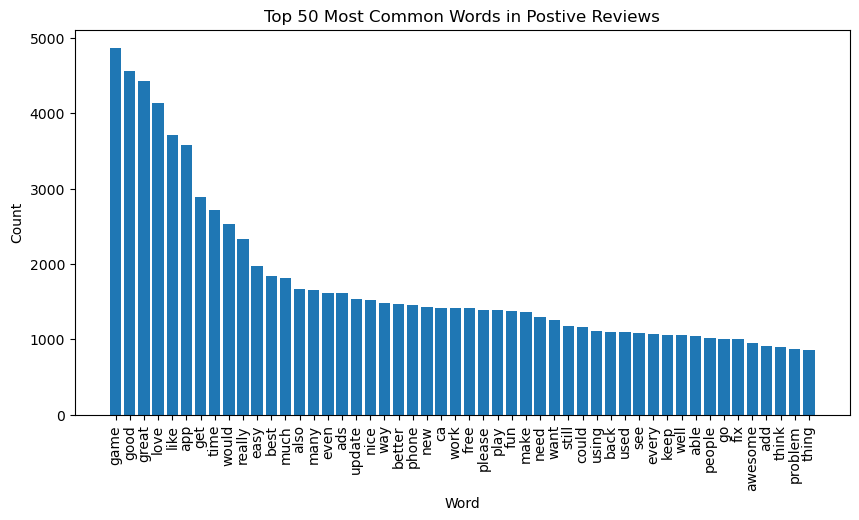

In [152]:
# Plotting the most common words in positive reviews
import matplotlib.pyplot as plt
%matplotlib inline

pos_keys = list(pos_freq.keys())    # words
pos_values = list(pos_freq.values())    # numer of occurences

plt.rcParams['figure.figsize'] = [10, 5]
plt.bar(range(50), pos_values[:50], tick_label = pos_keys[:50])
plt.xticks(rotation = 90)
plt.title('Top 50 Most Common Words in Postive Reviews')
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

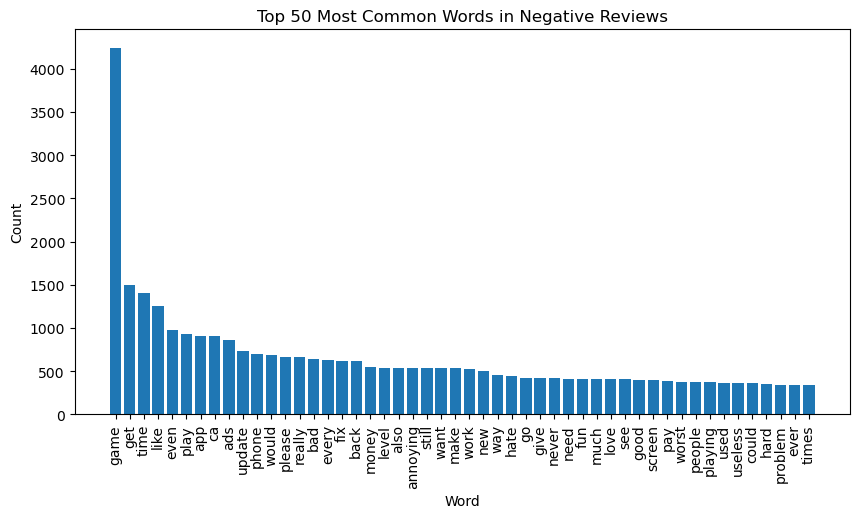

In [157]:
# Plotting the most common words in negative reviews
neg_keys = list(neg_freq.keys())    # words
neg_values = list(neg_freq.values())    # numer of occurences

plt.rcParams['figure.figsize'] = [10, 5]
plt.bar(range(50), neg_values[:50], tick_label = neg_keys[:50])
plt.xticks(rotation = 90)
plt.title('Top 50 Most Common Words in Negative Reviews')
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

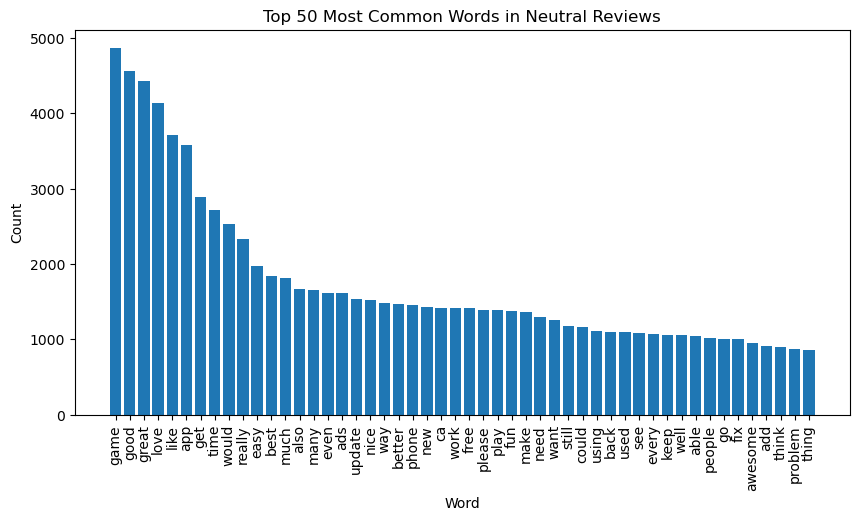

In [155]:
# Plotting the most common words in neutral reviews
nt_keys = list(nt_freq.keys())    # words
nt_values = list(nt_freq.values())    # numer of occurences

plt.rcParams['figure.figsize'] = [10, 5]
plt.bar(range(50), nt_values[:50], tick_label = nt_keys[:50])
plt.xticks(rotation = 90)
plt.title('Top 50 Most Common Words in Neutral Reviews')
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

From an initial look at the cleaned user review data we can immediately notice that we only have reviews for 816 of the 7 thousand apps that the other data set contained. This is likely due to the fact that the original user review data contained reviews of apps with no text in them, which indicates that the app was likely given a rating with no textual feedback from the users. The numeric data that we are given include the sentiment polarity and subjectivity, which indicate the general sentiment of the reviews and the personal attachment to the reviews respectively. 

Looking at the histograms of the most common 50 words  according to each type of review sentiment (positive, negative, and neutral) we can notice that each type of review has a similar distribution of words. While most reviews in each category mention games the most frequently, positive reviews more commonly feature words such as (good, love, like, etc.) that one would expect from positive reviews. The same can be said about negative reviews which more commonly include words such as (bad, annoying, fix, etc.). Interestingly enough, the reviews classified as neutral seem to include common words from both such as (love, great, fix, problem) but still seem to include more words from the positive distribution than the negative.

## Model

In [55]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [2]:
df = pd.read_csv('google_reviews_cleaned.csv')

df.pop('App')    # Don't want to use app name in model
df.head()

,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Rating,Review
0,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333,4.0,like eat delicious food cooking food case best...
1,This help eating healthy exercise regular basis,Positive,0.25,0.288462,4.0,help eating healthy exercise regular basis
2,Works great especially going grocery store,Positive,0.40,0.875000,4.0,works great especially going grocery store
3,Best idea us,Positive,1.00,0.300000,4.0,best idea us
4,Best way,Positive,1.00,0.300000,4.0,best way


In [51]:
# Training/Test Split
seed = 78432

y = df['Rating']
x = df['Review']

y_c = y.copy()
y_c = y_c.round().astype(int)


x_train, x_test, y_train, y_test = train_test_split(x, y_c, test_size = 0.2, random_state = seed)

In [52]:
# Vectorizing Data
vectorizer = TfidfVectorizer()

train_vectors = vectorizer.fit_transform(x_train.values.astype('str'))
test_vectors = vectorizer.transform(x_test.values.astype('str'))

In [54]:
# Multinomial Naive Bayes
mnb = MultinomialNB().fit(train_vectors, y_train)

In [68]:
# Model Accuracy
predicted = mnb.predict(test_vectors)
print('Multinomial NB accuracy:', metrics.accuracy_score(y_test ,predicted))

Multinomial NB accuracy: 0.7941831338714166


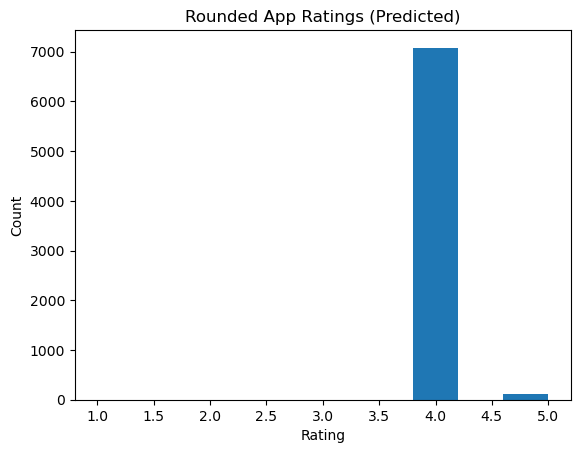

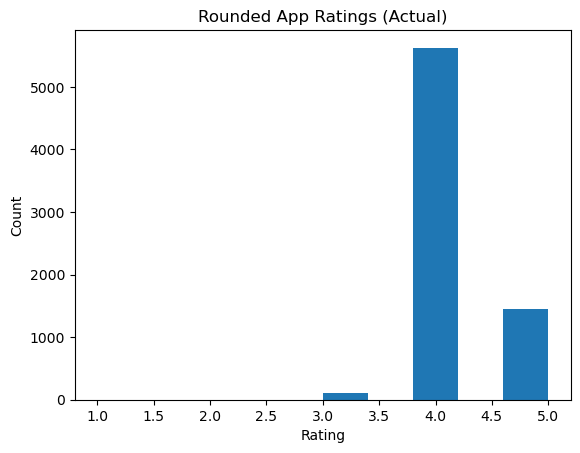

In [69]:
# Results Visualization

import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(predicted, range=[1,5])
plt.title('Rounded App Ratings (Predicted)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

plt.hist(y_test, range=[1,5])
plt.title('Rounded App Ratings (Actual)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## Results

I attempted to use a Naive Bayes model in order to predict user ratings, since Bayesian models are well equipped to handle language data. For the initial test, I chose to only train the model on the text of the reviews after processing. During the creation of the model, there were erros using the decimal values of the reviews, so I chose to train the model on the rounded integer ratings as a proof of concept. Using just the review data, the model performed with a 79.4% accuracy in predicting the rounded ratings, which was a slight improvement over the previous model. However, the oversimplification of the ratings themselves likely led to overfitting, since almost all of the predicted reviews were 4. Additionally, the reviews that had complete data seemed to only come from apps with 2.5 or more stars, meaning that it would be harder to predict app ratings below this value.

Moving forward, a combination of both models would likely be the most accurate solution possible. The current Naive Bayes model was insufficient for predicting the exact ratings, so combining the idea of natural language processing with the regression models from the first prototype will likely be the better alternative. That isn't to say that the current Bayes model is useless though, since it does showcase that the reviews for the apps are much more valuable for predicting ratings than many of the summary statistics.